<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_MLP_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597:- Multi-Layer Perceptron

## Load the libraries

In [2]:
import os
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import keras
import time
import math
import tensorflow as tf
import torch.nn as nn
from keras.datasets import fashion_mnist

seed=97238684
np.random.seed(seed)
tf.random.set_seed(seed)
# np.random.seed(1234)
# tf.random.set_seed(1234)
from sklearn.model_selection import train_test_split

In [3]:
tf.config.list_physical_devices('GPU')

[]

#Get number of Gpu's and id's in the system or else you can also use Nvidia-smi in command prompt.

## Generate random data

In [4]:
size_input = 784
size_hidden1 = 512
size_hidden2 = 256
size_hidden3 = 128
size_output = 10
starter_learning_rate = 0.001
regularizer_rate = 0.1

In [5]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=(1-train_ratio))
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=((test_ratio/(validation_ratio+test_ratio))))

X_train.shape

11501568/11490434 [==============================] - 0s 0us/step


(56000, 28, 28)

In [6]:

(Xtrain_fmnist, ytrain_fmnist), (Xtest_fmnist, ytest_fmnist) = fashion_mnist.load_data()
X_fmnist = np.concatenate([Xtrain_fmnist, Xtest_fmnist])
y_fmnist = np.concatenate([ytrain_fmnist, ytest_fmnist])

Xtrain_fmnist, X_val_fmnist, ytrain_fmnist, y_val_fmnist = train_test_split(X_fmnist, y_fmnist, test_size=(1-train_ratio))
X_val_fmnist, Xtest_fmnist, y_val_fmnist, ytest_fmnist = train_test_split(X_val_fmnist, y_val_fmnist, test_size=((test_ratio/(validation_ratio+test_ratio))))

4431872/4422102 [==============================] - 0s 0us/step


In [7]:

X_train = np.reshape(X_train, (56000, 784))
X_test = np.reshape(X_test, (-1, 784))
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255
X_val = np.reshape(X_val, (7000,784))
X_val=X_val/255.0
X_val=tf.cast(X_val,dtype=tf.float32)
y_train = tf.one_hot(y_train,10)
y_test = tf.one_hot(y_test,10)

In [8]:
Xtrain_fmnist = np.reshape(X_train, (56000, 784))
Xtest_fmnist = np.reshape(X_test, (-1, 784))
Xtrain_fmnist = Xtrain_fmnist.astype(float) / 255
Xtest_fmnist = Xtest_fmnist.astype(float) / 255
X_val_fmnist = np.reshape(X_val_fmnist, (7000,784))
X_val_fmnist=X_val_fmnist.astype(float) /255.0
ytrain_fmnist = tf.one_hot(ytrain_fmnist,10)
ytest_fmnist = tf.one_hot(ytest_fmnist,10)

In [9]:
print(X_train.shape, y_train.shape)
print(Xtrain_fmnist.shape, ytrain_fmnist.shape)
print("y_train: ",y_train)
print("y_val: ",y_val)
print("y_test: ",y_test)

(56000, 784) (56000, 10)
(56000, 784) (56000, 10)
y_train:  tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(56000, 10), dtype=float32)
y_val:  [4 2 6 ... 6 2 5]
y_test:  tf.Tensor(
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(7000, 10), dtype=float32)


In [10]:
# Split MNIST dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(2)

In [11]:
# Split FMNIST dataset into batches
train_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtrain_fmnist, ytrain_fmnist)).batch(16)
test_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtest_fmnist, ytest_fmnist)).batch(4)
val_ds_fmnist = tf.data.Dataset.from_tensor_slices((X_val_fmnist, y_val_fmnist)).batch(2)

## Build MLP using Eager Execution With L1 Regularization


In [12]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]))
    self.W_h1 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden1]))
     # Initialize weights between hidden layer and output layer
    self.W_h2 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3]))
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden3]))
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W_h1, self.W_h2, self.W2, self.b1, self.b2, self.b3, self.b4]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred,labels=y_true)) + \
        (tf.reduce_sum(tf.abs(self.W1)) + tf.reduce_sum(tf.abs(self.W_h1)) + tf.reduce_sum(tf.abs(self.W_h2))+tf.reduce_sum(tf.abs(self.W2)))
    return loss
    
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, epsilon=1e-07, amsgrad=False,
    name='Adam')
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    # Compute values in hidden layer
    what_i = tf.matmul(X_tf, self.W1) + self.b1
    hhat_i = tf.nn.relu(what_i)
    what_h1 = tf.matmul(hhat_i, self.W_h1) + self.b2
    hhat_h1 = tf.nn.relu(what_h1)
    what_h2 = tf.matmul(hhat_h1, self.W_h2) + self.b3
    hhat_h2 = tf.nn.relu(what_h2)

    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    output = tf.matmul(hhat_h2, self.W2) + self.b4
    output = tf.nn.softmax(output)
    #Second add tf.Softmax(output) and then return this variable
    return output

  # Calculate standard error
  def stderr(self,y_pred):
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    std_err = std_dev/sqrt(len(y_pred_tf))
    return std_err 

 # Calculate variance error
  def var(self,y_pred):
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    variance = (std_dev**2) # calculate variance
    return variance 
    
  def cat_accuracy(self, y_pred,y_true):
    return tf.cast(tf.equal(tf.argmax(y_true, axis=-1),tf.argmax(y_pred, axis=-1)),tf.keras.backend.floatx())


## Train Model

In [13]:
# Set number of epochs
NUM_EPOCHS = 10

In [13]:
# Initialize model using CPU MNIST Data with L1 regularization

mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()
acc_mnist=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy=0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    accuracy=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_mnist.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / X_train.shape[0], (100-(np.abs(np.sum(np.abs(accuracy)))/accuracy.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Average Cross Entropy:= 5084.5445714285715, Accuracy:= 99.95
Number of Epoch = 2 - Average Cross Entropy:= 18.948426339285714, Accuracy:= 99.8
Number of Epoch = 3 - Average Cross Entropy:= 14.278661830357143, Accuracy:= 99.85
Number of Epoch = 4 - Average Cross Entropy:= 14.278641741071429, Accuracy:= 99.8
Number of Epoch = 5 - Average Cross Entropy:= 14.278591517857143, Accuracy:= 99.8
Number of Epoch = 6 - Average Cross Entropy:= 14.278595982142857, Accuracy:= 99.85
Number of Epoch = 7 - Average Cross Entropy:= 14.2786015625, Accuracy:= 99.9
Number of Epoch = 8 - Average Cross Entropy:= 14.2786015625, Accuracy:= 99.85
Number of Epoch = 9 - Average Cross Entropy:= 14.2786015625, Accuracy:= 99.8
Number of Epoch = 10 - Average Cross Entropy:= 14.278602678571428, Accuracy:= 99.7

Total time taken (in seconds): 1518.94


In [ ]:

# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
acc_mnist_gpu=[]
time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_mnist_gpu=0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_mnist_gpu=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_mnist_gpu.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / X_train.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_mnist_gpu)))/accuracy_mnist_gpu.shape[0]))))
time_taken = time.time() - time_start


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Average MSE:= 4325.573
Number of Epoch = 2 - Average MSE:= 27.723109375
Number of Epoch = 3 - Average MSE:= 12.409765625
Number of Epoch = 4 - Average MSE:= 7.18881298828125
Number of Epoch = 5 - Average MSE:= 4.785166015625
Number of Epoch = 6 - Average MSE:= 3.5824267578125
Number of Epoch = 7 - Average MSE:= 2.8207646484375
Number of Epoch = 8 - Average MSE:= 2.42839990234375
Number of Epoch = 9 - Average MSE:= 2.052015625
Number of Epoch = 10 - Average MSE:= 1.837486572265625

Total time taken (in seconds): 4.07


In [14]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output)
acc_mnist_default=[]
time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_mnist_default=0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
    accuracy_mnist_default=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_mnist_default.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / X_train.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_mnist_default)))/accuracy_mnist_default.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Average Cross Entropy:= 14.278602678571428, Accuracy:= 99.75
Number of Epoch = 2 - Average Cross Entropy:= 14.278602678571428, Accuracy:= 99.9
Number of Epoch = 3 - Average Cross Entropy:= 14.278602678571428, Accuracy:= 99.8
Number of Epoch = 4 - Average Cross Entropy:= 14.278602678571428, Accuracy:= 99.8
Number of Epoch = 5 - Average Cross Entropy:= 14.278602678571428, Accuracy:= 99.9
Number of Epoch = 6 - Average Cross Entropy:= 14.278602678571428, Accuracy:= 99.75
Number of Epoch = 7 - Average Cross Entropy:= 14.278602678571428, Accuracy:= 99.9
Number of Epoch = 8 - Average Cross Entropy:= 14.278602678571428, Accuracy:= 99.85
Number of Epoch = 9 - Average Cross Entropy:= 14.278602678571428, Accuracy:= 99.85
Number of Epoch = 10 - Average Cross Entropy:= 14.278602678571428, Accuracy:= 99.85

Total time taken (in seconds): 1255.49


In [15]:
#TPU mode on MNIST data with L1 Regularization
mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='tpu')

print("TPU Model MNIST Data With L1 Regularization")
acc_mnist_tpu=[]
time_start = time.time()
accuracy_mnist_tpu=0
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_mnist_tpu=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_mnist_tpu.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_mnist_tpu)))/accuracy_mnist_tpu.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

TPU Model MNIST Data With L1 Regularization
Number of Epoch = 1 - Average Cross Entropy:= 5070.731428571428, Accuracy:= 100.0
Number of Epoch = 2 - Average Cross Entropy:= 18.52819642857143, Accuracy:= 99.95
Number of Epoch = 3 - Average Cross Entropy:= 14.27875892857143, Accuracy:= 99.8
Number of Epoch = 4 - Average Cross Entropy:= 14.278792410714285, Accuracy:= 99.8
Number of Epoch = 5 - Average Cross Entropy:= 14.278791294642858, Accuracy:= 99.9
Number of Epoch = 6 - Average Cross Entropy:= 14.278829241071428, Accuracy:= 99.75
Number of Epoch = 7 - Average Cross Entropy:= 14.278822544642857, Accuracy:= 99.9
Number of Epoch = 8 - Average Cross Entropy:= 14.278822544642857, Accuracy:= 99.85
Number of Epoch = 9 - Average Cross Entropy:= 14.2788125, Accuracy:= 99.85
Number of Epoch = 10 - Average Cross Entropy:= 14.278808035714286, Accuracy:= 99.85

Total time taken (in seconds): 1713.58


In [14]:
# Initialize model using CPU FMNIST Data with L1 regularization

mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()
acc_fmnist_cpu=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_fmnist_cpu=0
  train_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtrain_fmnist, ytrain_fmnist)).shuffle(25, seed=epoch*(seed)).batch(20)
  for inputs, outputs in train_ds_fmnist:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    accuracy_fmnist_cpu=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_fmnist_cpu.append(np.sum(loss_total) / Xtrain_fmnist.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / Xtrain_fmnist.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_fmnist_cpu)))/accuracy_fmnist_cpu.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Average Cross Entropy:= 5084.497714285714, Accuracy:= 99.85
Number of Epoch = 2 - Average Cross Entropy:= 18.948245535714285, Accuracy:= 99.9
Number of Epoch = 3 - Average Cross Entropy:= 14.278693080357144, Accuracy:= 99.85
Number of Epoch = 4 - Average Cross Entropy:= 14.278678571428571, Accuracy:= 99.8
Number of Epoch = 5 - Average Cross Entropy:= 14.278678571428571, Accuracy:= 99.95
Number of Epoch = 6 - Average Cross Entropy:= 14.278678571428571, Accuracy:= 99.85
Number of Epoch = 7 - Average Cross Entropy:= 14.278690848214286, Accuracy:= 99.95
Number of Epoch = 8 - Average Cross Entropy:= 14.278690848214286, Accuracy:= 100.0
Number of Epoch = 9 - Average Cross Entropy:= 14.278690848214286, Accuracy:= 99.95
Number of Epoch = 10 - Average Cross Entropy:= 14.278690848214286, Accuracy:= 99.9

Total time taken (in seconds): 1333.40


In [ ]:
# Initialize model using CPU FMNIST Data with L1 regularization

mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc_fmnist_gpu=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_fmnist_gpu=0
  train_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtrain_fmnist, ytrain_fmnist)).shuffle(25, seed=epoch*(seed)).batch(20)
  for inputs, outputs in train_ds_fmnist:
    preds = mlp_on_gpu.forward(inputs)
    loss_total = loss_total + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
    accuracy_fmnist_cpu=mlp_on_gpu.cat_accuracy(preds, outputs)
  acc_fmnist_gpu.append(np.sum(loss_total) / Xtrain_fmnist.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / Xtrain_fmnist.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_fmnist_gpu)))/accuracy_fmnist_gpu.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

In [15]:
# Initialize model using CPU FMNIST Data with L1 regularization

mlp_on_tpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='tpu')

time_start = time.time()
acc_fmnist_tpu=[]
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_fmnist_tpu=0
  train_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtrain_fmnist, ytrain_fmnist)).shuffle(25, seed=epoch*(seed)).batch(20)
  for inputs, outputs in train_ds_fmnist:
    preds = mlp_on_tpu.forward(inputs)
    loss_total = loss_total + mlp_on_tpu.loss(preds, outputs)
    lt = lt + mlp_on_tpu.loss(preds, outputs)
    mlp_on_tpu.backward(inputs, outputs)
    accuracy_fmnist_tpu=mlp_on_tpu.cat_accuracy(preds, outputs)
  acc_fmnist_tpu.append(np.sum(loss_total) / Xtrain_fmnist.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / Xtrain_fmnist.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_fmnist_tpu)))/accuracy_fmnist_tpu.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Average Cross Entropy:= 5071.617142857142, Accuracy:= 99.95
Number of Epoch = 2 - Average Cross Entropy:= 18.821868303571428, Accuracy:= 99.85
Number of Epoch = 3 - Average Cross Entropy:= 14.278353794642857, Accuracy:= 99.95
Number of Epoch = 4 - Average Cross Entropy:= 14.278410714285714, Accuracy:= 99.8
Number of Epoch = 5 - Average Cross Entropy:= 14.278410714285714, Accuracy:= 99.95
Number of Epoch = 6 - Average Cross Entropy:= 14.278409598214285, Accuracy:= 99.85
Number of Epoch = 7 - Average Cross Entropy:= 14.278410714285714, Accuracy:= 99.95
Number of Epoch = 8 - Average Cross Entropy:= 14.278410714285714, Accuracy:= 99.8
Number of Epoch = 9 - Average Cross Entropy:= 14.278410714285714, Accuracy:= 99.95
Number of Epoch = 10 - Average Cross Entropy:= 14.278411830357143, Accuracy:= 99.9

Total time taken (in seconds): 1356.76


In [16]:
#Default mode FMNIST Data Default

mlp_on_default = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output)
acc_fmnist_default=[]
time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_fmnist_default=0
  train_ds_fmnist = tf.data.Dataset.from_tensor_slices((Xtrain_fmnist, ytrain_fmnist)).shuffle(25, seed=epoch*(seed)).batch(20)
  for inputs, outputs in train_ds_fmnist:
    preds = mlp_on_default.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
    accuracy_fmnist_default=mlp_on_cpu.cat_accuracy(preds, outputs)
  acc_fmnist_default.append(np.sum(loss_total) / X_train.shape[0])
  print('Number of Epoch = {} - Average Cross Entropy:= {}, Accuracy:= {}'.format(epoch + 1, np.sum(loss_total) / Xtrain_fmnist.shape[0], (100-(np.abs(np.sum(np.abs(accuracy_fmnist_default)))/accuracy_fmnist_default.shape[0]))))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Average Cross Entropy:= 14.278411830357143, Accuracy:= 99.85
Number of Epoch = 2 - Average Cross Entropy:= 14.278411830357143, Accuracy:= 99.95
Number of Epoch = 3 - Average Cross Entropy:= 14.278411830357143, Accuracy:= 99.9
Number of Epoch = 4 - Average Cross Entropy:= 14.278411830357143, Accuracy:= 99.9
Number of Epoch = 5 - Average Cross Entropy:= 14.278411830357143, Accuracy:= 99.95
Number of Epoch = 6 - Average Cross Entropy:= 14.278411830357143, Accuracy:= 99.85
Number of Epoch = 7 - Average Cross Entropy:= 14.278411830357143, Accuracy:= 99.85
Number of Epoch = 8 - Average Cross Entropy:= 14.278411830357143, Accuracy:= 99.85
Number of Epoch = 9 - Average Cross Entropy:= 14.278411830357143, Accuracy:= 99.9
Number of Epoch = 10 - Average Cross Entropy:= 14.278411830357143, Accuracy:= 99.9

Total time taken (in seconds): 1299.65


## One Step Inference

In [17]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_train.shape[0]))

Test MSE: 8.9170


In [18]:
# Initialize
from numpy import sqrt
test_loss_total = tf.Variable(0, dtype=tf.float32)
acc_preds = tf.Variable(0,dtype=tf.float32)
acc = tf.Variable(0, dtype=tf.float32)

# Calculate
for inputs, outputs in test_ds:

  preds = mlp_on_cpu.forward(inputs) # Prediction
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds,outputs) # Loss
  standard_error = mlp_on_cpu.stderr(preds) # Standard error
  Variance = mlp_on_cpu.var(preds) # Variance

  for i in range(preds.shape[0]):
    if tf.argmax(preds[i])==tf.argmax(outputs[i]):
      acc_preds = acc_preds + 1.0
acc = (acc_preds/X_test.shape[0])*100.0
print('Inference 1st')
print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy())/X_train.shape[0]))
print('Accuracy: {:.4f}'.format(acc))
print('Standard Error: {:.4f}'.format(standard_error))
print('Variance: {:.4f}'.format(Variance))

Inference 1st
Test MSE: 8.9170
Accuracy: 10.0286
Standard Error: 0.0003
Variance: 0.0000


In [19]:
# Initialize
from numpy import sqrt
test_loss_total = tf.Variable(0, dtype=tf.float32)
acc_preds = tf.Variable(0,dtype=tf.float32)
acc = tf.Variable(0, dtype=tf.float32)

# Calculate
for inputs, outputs in test_ds_fmnist:

  preds = mlp_on_cpu.forward(inputs) # Prediction
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds,outputs) # Loss
  standard_error = mlp_on_cpu.stderr(preds) # Standard error
  Variance = mlp_on_cpu.var(preds) # Variance

  for i in range(preds.shape[0]):
    if tf.argmax(preds[i])==tf.argmax(outputs[i]):
      acc_preds = acc_preds + 1.0
acc = (acc_preds/Xtest_fmnist.shape[0])*100.0
print('Inference 1st')
print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy())/Xtrain_fmnist.shape[0]))
print('Accuracy: {:.4f}'.format(acc))
print('Standard Error: {:.4f}'.format(standard_error))
print('Variance: {:.4f}'.format(Variance))

Inference 1st
Test MSE: 8.9170
Accuracy: 10.0571
Standard Error: 0.0003
Variance: 0.0000


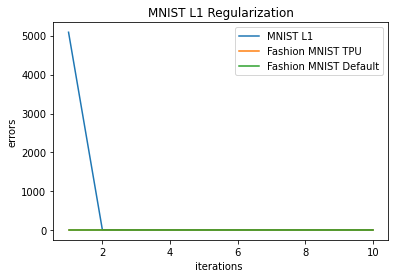

In [19]:
# Plot learning curve (with errors)
import matplotlib.pyplot as plt
%matplotlib inline
iterations = [1,2,3,4,5,6,7,8,9,10]
errors = np.squeeze(acc_mnist)
# errors_gpu = np.squeeze(acc_mnist_gpu)
errors_tpu = np.squeeze(acc_mnist_tpu)
errors_default = np.squeeze(acc_mnist_default)
plt.plot(iterations,errors,label='MNIST L1')
# plt.plot(iterations,errors_gpu,label='MNIST L1 GPU')
plt.plot(iterations,errors_tpu,label='Fashion MNIST TPU')
plt.plot(iterations,errors_default,label='Fashion MNIST Default')
plt.ylabel('errors')
plt.xlabel('iterations ')
plt.title("MNIST L1 Regularization")
plt.legend()
plt.show()

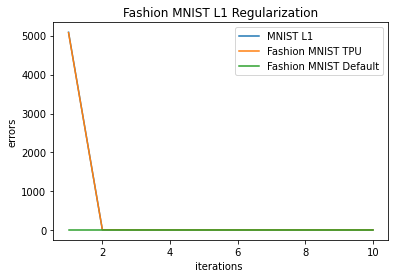

In [22]:
# Plot learning curve (with errors)
import matplotlib.pyplot as plt
%matplotlib inline
iterations = [1,2,3,4,5,6,7,8,9,10]
errors = np.squeeze(acc_fmnist_cpu)
# errors_gpu = np.squeeze(acc_mnist_gpu)
errors_tpu = np.squeeze(acc_fmnist_tpu)
errors_default = np.squeeze(acc_fmnist_default)
plt.plot(iterations,errors,label='MNIST L1')
# plt.plot(iterations,errors_gpu,label='MNIST L1 GPU')
plt.plot(iterations,errors_tpu,label='Fashion MNIST TPU')
plt.plot(iterations,errors_default,label='Fashion MNIST Default')
plt.ylabel('errors')
plt.xlabel('iterations ')
plt.title("Fashion MNIST L1 Regularization")
plt.legend()
plt.show()